# Import

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors

import pathlib

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 20

# Read Data

In [3]:
qm9 = pd.read_csv("qm_ext_plus.csv")
qm9.index = qm9["Unnamed: 0"]
qm9.drop(columns=["Unnamed: 0"], inplace=True)
qm9["mol"] = qm9["smiles"].apply(Chem.MolFromSmiles)

In [4]:
qm9.dropna()

,smiles,mu,alpha,homo,lumo,gap,zpve,cv,u0,u298,h298,g298,num_atoms,mol
Unnamed: 0,,,,,,,,,,,,,,
0,C,0.0000,13.210000,-0.387700,0.117100,0.504800,0.044749,6.469,-40.478930,-40.476062,-40.475117,-40.498597,1,<rdkit.Chem.rdchem.Mol object at 0x7f51b070cfa0>
1,N,1.6256,9.460000,-0.257000,0.082900,0.339900,0.034358,6.316,-56.525887,-56.523026,-56.522082,-56.544961,1,<rdkit.Chem.rdchem.Mol object at 0x7f51b070cf40>
2,O,1.8511,6.310000,-0.292800,0.068700,0.361500,0.021375,6.002,-76.404702,-76.401867,-76.400922,-76.422349,1,<rdkit.Chem.rdchem.Mol object at 0x7f51b070ce80>
3,C#C,0.0000,16.280000,-0.284500,0.050600,0.335100,0.026841,8.574,-77.308427,-77.305527,-77.304583,-77.327429,2,<rdkit.Chem.rdchem.Mol object at 0x7f51b070d000>
4,C#N,2.8937,12.990000,-0.360400,0.019100,0.379600,0.016601,6.278,-93.411888,-93.409370,-93.408425,-93.431246,2,<rdkit.Chem.rdchem.Mol object at 0x7f51b070ca60>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155584,CCCCCC(Cl)(Cl)Cl,1.6998,91.438949,-0.437290,0.151861,0.589151,0.160407,39.627,-1612.899018,-1615.123029,-1612.726294,-1612.777780,9,<rdkit.Chem.rdchem.Mol object at 0x7f51aecba2c0>
155585,CCCNCC(Cl)(Cl)Cl,1.0758,88.241518,-0.375428,0.153217,0.528645,0.149152,39.102,-1628.886186,-1631.151460,-1628.724865,-1628.775694,9,<rdkit.Chem.rdchem.Mol object at 0x7f51aecba320>
155586,CCCOCC(Cl)(Cl)Cl,5.6070,83.982178,-0.429966,0.153852,0.583818,0.136714,37.858,-1648.698216,-1651.009167,-1648.549519,-1648.600105,9,<rdkit.Chem.rdchem.Mol object at 0x7f51aecba380>


In [5]:
db_conf = pd.read_parquet("db_conf.parquet")
db_conf.index = db_conf["db_idx"]
db_conf.drop(columns=["Unnamed: 0", "db_idx"], inplace=True)
db_conf["mol"] = db_conf["smiles"].apply(Chem.MolFromSmiles)
# db_conf.drop(columns=["CONF", "CONFCl", "CONFClBr", "CONFClBrI"], inplace=True)
db_conf = db_conf.reset_index(drop=True)

In [6]:
na_ind = db_conf[db_conf.iloc[:,4:-1].isna().all(axis=1)].index

In [7]:
db_conf = db_conf.drop(index=na_ind)
db_conf = db_conf.reset_index(drop=True)

# Labels Encoding

In [8]:
from sklearn import preprocessing

In [9]:
le = preprocessing.LabelEncoder()
le.fit(["nB", "B"])
db_conf["class_encoded"] = le.transform(db_conf["Experimental BCF class"])

In [10]:
db_conf["class_encoded"] = db_conf["class_encoded"].replace({1:0, 0:1})

In [11]:
db_conf

,smiles,Experimental logarithmic BCF,Experimental BCF class,FQD_2,FQD_3,FQD_4,FQD_5,FQD_6,FQD_7,FQD_8,FQD_9,mol,class_encoded
0,CNc1cccc(C)c1,0.849,nB,[6],None,None,None,[213],"[929, 939]","[4340, 5388]",[32107],<rdkit.Chem.rdchem.Mol object at 0x7f51aed127a0>,0
1,CC(COc1ccc(Oc2ccccc2)cc1)Oc1ccccn1,3.140,B,"[6, 7]","[12, 13, 14]","[21, 39, 40, 41]","[81, 84, 134, 136]","[213, 214, 277, 395, 548]","[948, 953, 1578]","[4590, 5397, 5402]","[31844, 33001, 33006]",<rdkit.Chem.rdchem.Mol object at 0x7f51aed12da0>,1
2,CCCCCCCC/C=C\CCCCCCCCCCCCC,1.176,nB,[6],[12],[38],[132],[542],[2719],[14787],[123245],<rdkit.Chem.rdchem.Mol object at 0x7f51ac1af0a0>,0
3,Clc1ccccc1Cl,2.500,nB,None,None,None,None,[213],[134076],[135441],None,<rdkit.Chem.rdchem.Mol object at 0x7f51ac1aef80>,0
4,Nc1cccc([N+](=O)[O-])c1,0.522,nB,None,None,None,None,[213],[939],[4360],[131914],<rdkit.Chem.rdchem.Mol object at 0x7f51ac1aef20>,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,CC1=C(C)S(=O)(=O)CCS1(=O)=O,0.633,nB,[6],None,None,None,"[133896, 133900]","[134043, 134044, 134066, 134068]","[135086, 135404, 135405]",[145115],<rdkit.Chem.rdchem.Mol object at 0x7f51ac19b5e0>,0
835,FC(F)(F)c1ccc(Cl)c(Cl)c1,3.176,B,[6],None,None,None,[213],"[929, 134076]","[134378, 134382, 135441]",[137748],<rdkit.Chem.rdchem.Mol object at 0x7f51ac19b640>,1
836,CN(C)[C@@H]1C(=O)C(C(=N)O)=C(O)[C@@]2(O)C(=O)C...,-0.222,nB,"[5, 6, 7]","[10, 12, 13]","[17, 20, 21, 34, 37, 38, 39, 41]","[54, 67, 68, 70, 71, 80, 81, 82, 83, 127, 131,...","[213, 224, 226, 228, 254, 258, 259, 260, 271, ...","[929, 948, 1092, 1094, 1099, 1104, 1119, 1129,...","[4341, 4957, 4959, 5378, 5407, 5809, 5841, 584...","[26263, 26273, 28867, 32083, 32170, 32193, 322...",<rdkit.Chem.rdchem.Mol object at 0x7f51ac19b6a0>,0
837,CC(C)N(C(=O)CCl)c1ccccc1,1.568,nB,"[5, 6]","[10, 11, 12]","[18, 35]","[69, 73, 128]","[213, 255, 262, 288, 386]","[939, 1121, 1626, 1677]","[5388, 7443]","[25503, 26283, 32992]",<rdkit.Chem.rdchem.Mol object at 0x7f51ac19b700>,0


In [12]:
db_conf["mol"] = db_conf["smiles"].apply(Chem.MolFromSmiles)
db_conf["num_atoms"] = db_conf["mol"].apply(lambda x: x.GetNumAtoms())

# Generate FQDs

In [13]:
db_conf_filled = db_conf.copy()

In [14]:
qprops = "mu,alpha,homo,lumo,gap,zpve,u0,u298,h298,g298,cv".split(",")

In [15]:
import statistics
def calculate_FQDs(indices, patterns_db, quantum_property):
    if isinstance(indices, int) and indices == 0:
        return np.NaN
    if indices is None:
        return np.NaN
    ret = []
    for i in indices:
        ret.append(patterns_db[quantum_property][i])
    return statistics.mean(ret)

def calculate_FQDs_quant(mol, indices, patterns_db, quantum_property):
    if isinstance(indices, int) and indices == 0:
        return np.NaN
    if indices is None:
        return np.NaN
    ret = []
    for i in indices:
        n_occurences = len(list(mol.GetSubstructMatch(patterns_db["mol"][i])))
        ret.append(patterns_db[quantum_property][i] * n_occurences)
    return statistics.mean(ret)

In [16]:
# for prop in qprops:
#     for num in range(2, 10):
#         db_conf_filled[f"FQD_{num}_{prop}"] = db_conf_filled[f"FQD_{num}"].apply(calculate_FQDs, patterns_db=qm9, quantum_property=prop)

In [17]:
# for prop in qprops:
#     for num in range(2, 10):
#         db_conf_filled[f"FQD_{num}_{prop}_per_atom"] = db_conf_filled[f"FQD_{num}_{prop}"] / db_conf_filled["num_atoms"]

# Quant FQDs

In [18]:
for prop in qprops:
    for num in range(2, 10):
        db_conf_filled[f"quant_FQD_{num}_{prop}"] = db_conf_filled["mol"].apply(lambda x: calculate_FQDs_quant(x,
                                                                          indices=db_conf_filled[db_conf_filled["mol"]==x][f"FQD_{num}"].iloc[0],
                                                                          patterns_db=qm9,
                                                                          quantum_property=prop)
                                                                         )

In [19]:
for prop in qprops:
    for num in range(2, 10):
        db_conf_filled[f"quant_FQD_{num}_{prop}_per_atom"] = db_conf_filled[f"quant_FQD_{num}_{prop}"] / db_conf_filled["num_atoms"]

In [20]:
nan_cols = db_conf.iloc[:,4:12].isna()

In [21]:
db_conf_filled = db_conf_filled.fillna(0)

In [22]:
nan_cols_colnames = [f"{x}_nan" for x in nan_cols]
nan_cols.columns = nan_cols_colnames
fqd_columns = list(db_conf_filled.columns[15:])
nan_cols

,FQD_3_nan,FQD_4_nan,FQD_5_nan,FQD_6_nan,FQD_7_nan,FQD_8_nan,FQD_9_nan,mol_nan
0,True,True,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,True,True,True,False,False,False,True,False
4,True,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...
834,True,True,True,False,False,False,False,False
835,True,True,True,False,False,False,False,False
836,False,False,False,False,False,False,False,False
837,False,False,False,False,False,False,False,False


In [23]:
db_conf_filled = pd.concat([db_conf_filled, nan_cols], axis=1)
db_conf_filled

,smiles,Experimental logarithmic BCF,Experimental BCF class,FQD_2,FQD_3,FQD_4,FQD_5,FQD_6,FQD_7,FQD_8,...,quant_FQD_8_cv_per_atom,quant_FQD_9_cv_per_atom,FQD_3_nan,FQD_4_nan,FQD_5_nan,FQD_6_nan,FQD_7_nan,FQD_8_nan,FQD_9_nan,mol_nan
0,CNc1cccc(C)c1,0.849,nB,[6],0,0,0,[213],"[929, 939]","[4340, 5388]",...,25.429333,34.071000,True,True,True,False,False,False,False,False
1,CC(COc1ccc(Oc2ccccc2)cc1)Oc1ccccn1,3.140,B,"[6, 7]","[12, 13, 14]","[21, 39, 40, 41]","[81, 84, 134, 136]","[213, 214, 277, 395, 548]","[948, 953, 1578]","[4590, 5397, 5402]",...,8.696556,11.601875,False,False,False,False,False,False,False,False
2,CCCCCCCC/C=C\CCCCCCCCCCCCC,1.176,nB,[6],[12],[38],[132],[542],[2719],[14787],...,13.616348,17.217000,False,False,False,False,False,False,False,False
3,Clc1ccccc1Cl,2.500,nB,0,0,0,0,[213],[134076],[135441],...,24.767000,0.000000,True,True,True,False,False,False,True,False
4,Nc1cccc([N+](=O)[O-])c1,0.522,nB,0,0,0,0,[213],[939],[4360],...,23.248000,23.053500,True,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,CC1=C(C)S(=O)(=O)CCS1(=O)=O,0.633,nB,[6],0,0,0,"[133896, 133900]","[134043, 134044, 134066, 134068]","[135086, 135404, 135405]",...,23.407333,30.375750,True,True,True,False,False,False,False,False
835,FC(F)(F)c1ccc(Cl)c(Cl)c1,3.176,B,[6],0,0,0,[213],"[929, 134076]","[134378, 134382, 135441]",...,16.680667,21.668250,True,True,True,False,False,False,False,False
836,CN(C)[C@@H]1C(=O)C(C(=N)O)=C(O)[C@@]2(O)C(=O)C...,-0.222,nB,"[5, 6, 7]","[10, 12, 13]","[17, 20, 21, 34, 37, 38, 39, 41]","[54, 67, 68, 70, 71, 80, 81, 82, 83, 127, 131,...","[213, 224, 226, 228, 254, 258, 259, 260, 271, ...","[929, 948, 1092, 1094, 1099, 1104, 1119, 1129,...","[4341, 4957, 4959, 5378, 5407, 5809, 5841, 584...",...,8.633506,10.959239,False,False,False,False,False,False,False,False
837,CC(C)N(C(=O)CCl)c1ccccc1,1.568,nB,"[5, 6]","[10, 11, 12]","[18, 35]","[69, 73, 128]","[213, 255, 262, 288, 386]","[939, 1121, 1626, 1677]","[5388, 7443]",...,18.348571,20.109643,False,False,False,False,False,False,False,False


# Generate RDKit descriptors

In [24]:
descriptors_names = [ x[0] for x in Descriptors._descList ] #list of all RDKit Descriptors
calculator = MoleculeDescriptors.MolecularDescriptorCalculator( descriptors_names )
descriptors = pd.DataFrame()
maccs_keys = pd.DataFrame()
morgan_fp = pd.DataFrame()
for mol in db_conf_filled["mol"]:
    descriptors = descriptors.append([calculator.CalcDescriptors(mol)])
    maccs_keys = maccs_keys.append(pd.Series(np.asarray(MACCSkeys.GenMACCSKeys(mol))), ignore_index=True)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=2048)
    fp_vect = np.zeros((1,))
    AllChem.DataStructs.ConvertToNumpyArray(fp, fp_vect)
    morgan_fp = morgan_fp.append(pd.Series(fp_vect), ignore_index=True)
cols_rdkit = descriptors_names + [f"MACCS_key{x}" for x in range(maccs_keys.shape[1])] + [f"MorganFP_bit_{x}" for x in range(2048)]
cols = list(db_conf_filled.columns) + cols_rdkit
dat3 = pd.concat([db_conf_filled.reset_index(drop=True), descriptors.reset_index(drop=True), maccs_keys.reset_index(drop=True), morgan_fp.reset_index(drop=True)], axis=1)
dat3.columns = cols


/tmp/ipykernel_8115/1649868277.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  descriptors = descriptors.append([calculator.CalcDescriptors(mol)])
/tmp/ipykernel_8115/1649868277.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maccs_keys = maccs_keys.append(pd.Series(np.asarray(MACCSkeys.GenMACCSKeys(mol))), ignore_index=True)
/tmp/ipykernel_8115/1649868277.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  morgan_fp = morgan_fp.append(pd.Series(fp_vect), ignore_index=True)
/tmp/ipykernel_8115/1649868277.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  descriptors = descriptors.append([calculator.CalcDescriptors(mol)])
/tmp/

In [25]:
bin_cols = [f"MACCS_key{x}" for x in range(maccs_keys.shape[1])] + [f"MorganFP_bit_{x}" for x in range(2048)]

In [26]:
dat3

,smiles,Experimental logarithmic BCF,Experimental BCF class,FQD_2,FQD_3,FQD_4,FQD_5,FQD_6,FQD_7,FQD_8,...,MorganFP_bit_2038,MorganFP_bit_2039,MorganFP_bit_2040,MorganFP_bit_2041,MorganFP_bit_2042,MorganFP_bit_2043,MorganFP_bit_2044,MorganFP_bit_2045,MorganFP_bit_2046,MorganFP_bit_2047
0,CNc1cccc(C)c1,0.849,nB,[6],0,0,0,[213],"[929, 939]","[4340, 5388]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CC(COc1ccc(Oc2ccccc2)cc1)Oc1ccccn1,3.140,B,"[6, 7]","[12, 13, 14]","[21, 39, 40, 41]","[81, 84, 134, 136]","[213, 214, 277, 395, 548]","[948, 953, 1578]","[4590, 5397, 5402]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CCCCCCCC/C=C\CCCCCCCCCCCCC,1.176,nB,[6],[12],[38],[132],[542],[2719],[14787],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Clc1ccccc1Cl,2.500,nB,0,0,0,0,[213],[134076],[135441],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Nc1cccc([N+](=O)[O-])c1,0.522,nB,0,0,0,0,[213],[939],[4360],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,CC1=C(C)S(=O)(=O)CCS1(=O)=O,0.633,nB,[6],0,0,0,"[133896, 133900]","[134043, 134044, 134066, 134068]","[135086, 135404, 135405]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
835,FC(F)(F)c1ccc(Cl)c(Cl)c1,3.176,B,[6],0,0,0,[213],"[929, 134076]","[134378, 134382, 135441]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
836,CN(C)[C@@H]1C(=O)C(C(=N)O)=C(O)[C@@]2(O)C(=O)C...,-0.222,nB,"[5, 6, 7]","[10, 12, 13]","[17, 20, 21, 34, 37, 38, 39, 41]","[54, 67, 68, 70, 71, 80, 81, 82, 83, 127, 131,...","[213, 224, 226, 228, 254, 258, 259, 260, 271, ...","[929, 948, 1092, 1094, 1099, 1104, 1119, 1129,...","[4341, 4957, 4959, 5378, 5407, 5809, 5841, 584...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
837,CC(C)N(C(=O)CCl)c1ccccc1,1.568,nB,"[5, 6]","[10, 11, 12]","[18, 35]","[69, 73, 128]","[213, 255, 262, 288, 386]","[939, 1121, 1626, 1677]","[5388, 7443]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
dat3.columns[14:]

Index(['quant_FQD_2_mu', 'quant_FQD_3_mu', 'quant_FQD_4_mu', 'quant_FQD_5_mu',
       'quant_FQD_6_mu', 'quant_FQD_7_mu', 'quant_FQD_8_mu', 'quant_FQD_9_mu',
       'quant_FQD_2_alpha', 'quant_FQD_3_alpha',
       ...
       'MorganFP_bit_2038', 'MorganFP_bit_2039', 'MorganFP_bit_2040',
       'MorganFP_bit_2041', 'MorganFP_bit_2042', 'MorganFP_bit_2043',
       'MorganFP_bit_2044', 'MorganFP_bit_2045', 'MorganFP_bit_2046',
       'MorganFP_bit_2047'],
      dtype='object', length=2607)

In [28]:
x = dat3.iloc[:, 14:]
y = dat3["class_encoded"]

In [29]:
x

,quant_FQD_2_mu,quant_FQD_3_mu,quant_FQD_4_mu,quant_FQD_5_mu,quant_FQD_6_mu,quant_FQD_7_mu,quant_FQD_8_mu,quant_FQD_9_mu,quant_FQD_2_alpha,quant_FQD_3_alpha,...,MorganFP_bit_2038,MorganFP_bit_2039,MorganFP_bit_2040,MorganFP_bit_2041,MorganFP_bit_2042,MorganFP_bit_2043,MorganFP_bit_2044,MorganFP_bit_2045,MorganFP_bit_2046,MorganFP_bit_2047
0,0.000000,0.0000,0.00000,0.000000,0.000000,6.848800,13.020800,14.40630,47.900000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.525800,2.6230,3.80990,8.173250,7.871760,5.880933,4.931733,12.29910,40.920000,90.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.1791,0.00000,0.301500,0.000000,0.422100,0.000000,0.54180,47.900000,104.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0000,0.00000,0.000000,0.000000,-0.000700,-21.363200,0.00000,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0000,0.00000,0.000000,0.000000,11.422600,9.324000,39.49380,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,0.000000,0.0000,0.00000,0.000000,-3.479100,-10.527475,-11.717333,16.39350,47.900000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
835,0.000000,0.0000,0.00000,0.000000,0.000000,1.137150,-18.736800,-27.43740,47.900000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
836,2.423133,4.0410,5.00385,9.239357,9.384406,12.560830,15.701759,18.30079,36.733333,87.73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
837,2.108900,6.3565,14.68760,18.250833,17.415000,21.800975,20.810000,21.11280,38.130000,81.43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# OOB dataset creation

In [30]:
oob_idx = np.loadtxt("oob_idx").astype(int)
train_idx = np.loadtxt("train_idx").astype(int)

In [31]:
res_x, res_y = x.loc[list(train_idx.astype(int))], y.loc[list(train_idx.astype(int))]

In [32]:
oob_x, oob_y = x.loc[list(oob_idx)], y.loc[list(oob_idx)]

In [33]:
x, y = res_x, res_y

In [34]:
y.value_counts()

0    409
1    117
Name: class_encoded, dtype: int64

# Modelling

# Pipeline creation

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
import xgboost as xgb
import lightgbm as lgb

In [44]:
scor_dict = {"algorithm": [],
            "balanced_accuracy": [],
            "f1 score": []}

In [45]:
from sklearn.model_selection import StratifiedKFold

def my_score(model, n_folds, scoring_callable, X, Y):
    scores = [],[]
    cv = StratifiedKFold(n_folds)
    oversampler = RandomOverSampler(random_state=1)
    preprocessor = ColumnTransformer(
        [("prep", Pipeline([
            ("scaler", StandardScaler()),
        ]),
                                     fqd_columns+descriptors_names)], remainder="passthrough")

    for train_index, validation_index in cv.split(X, Y):
        x, y = X.iloc[train_index], Y.iloc[train_index]
        xx, yy = oversampler.fit_resample(x, y)
        xx = preprocessor.fit_transform(xx)
        model.fit(xx, yy)
        x_val = X.iloc[validation_index]
        x_val = preprocessor.transform(x_val)
        score_bac = scoring_callable[0](Y.iloc[validation_index], model.predict(x_val))
        score_f = scoring_callable[1](Y.iloc[validation_index], model.predict(x_val))
        
        print(f"bac: {score_bac}, f1: {score_f}")
        scores[0].append(score_bac)
        scores[1].append(score_f)
    
    return scores

### LogClf

In [46]:
scor_dict["algorithm"].extend(["Logistic Regression"]*5)

In [47]:
reg = LogisticRegression(max_iter=100000)

In [48]:
scores = my_score(reg, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.8373983739837398, f1: 0.7017543859649124
bac: 0.8611111111111112, f1: 0.7547169811320755
bac: 0.8425238600212089, f1: 0.7346938775510203
bac: 0.767762460233298, f1: 0.6511627906976744
bac: 0.8112407211028632, f1: 0.711111111111111


In [49]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [50]:
scor_dict["f1 score"].extend(list(scores[1]))

### Rand Forest

In [51]:
scor_dict["algorithm"].extend(["Random Forest"]*5)

In [52]:
clf = RandomForestClassifier(
            n_estimators=1000,
            max_features=0.3,
            random_state=1
)

In [53]:
scores = my_score(clf, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.8556910569105691, f1: 0.7407407407407408
bac: 0.9189814814814814, f1: 0.875
bac: 0.8173382820784729, f1: 0.7272727272727272
bac: 0.7364793213149523, f1: 0.6153846153846153
bac: 0.7364793213149523, f1: 0.6153846153846153


In [54]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [55]:
scor_dict["f1 score"].extend(list(scores[1]))

### Grad Boosting

In [56]:
scor_dict["algorithm"].extend(["Gradient Boosting"]*5)

In [57]:
gbc = GradientBoostingClassifier(
            n_estimators=1000,
            max_features=0.3,
            random_state = 1,
)

In [58]:
scores = my_score(gbc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.7748983739837398, f1: 0.6296296296296297
bac: 0.933641975308642, f1: 0.8799999999999999
bac: 0.7990455991516436, f1: 0.6808510638297872
bac: 0.7582184517497348, f1: 0.65
bac: 0.752120890774125, f1: 0.6341463414634146


In [59]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [60]:
scor_dict["f1 score"].extend(list(scores[1]))

### KNN

In [61]:
scor_dict["algorithm"].extend(["KNN"]*5)

In [62]:
from sklearn.neighbors import KNeighborsClassifier

In [63]:
knc = KNeighborsClassifier()

In [64]:
scores = my_score(knc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.7571138211382114, f1: 0.5569620253164558
bac: 0.7785493827160493, f1: 0.6129032258064516
bac: 0.8032873806998939, f1: 0.6333333333333333
bac: 0.7815482502651114, f1: 0.6101694915254238
bac: 0.7449628844114529, f1: 0.5538461538461539


In [65]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [66]:
scor_dict["f1 score"].extend(list(scores[1]))

### SVC

In [67]:
scor_dict["algorithm"].extend(["SVC"]*5)

In [68]:
from sklearn.svm import SVC

In [69]:
svc = SVC(kernel="poly", degree=4)

In [70]:
scores = my_score(svc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.7784552845528455, f1: 0.6530612244897959
bac: 0.8171296296296297, f1: 0.723404255319149
bac: 0.8573700954400848, f1: 0.8095238095238095
bac: 0.7555673382820784, f1: 0.6222222222222223
bac: 0.7025450689289502, f1: 0.55


In [71]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [72]:
scor_dict["f1 score"].extend(list(scores[1]))

### XGBoost

In [73]:
scor_dict["algorithm"].extend(["XGBoost"]*5)

In [74]:
xgbc = xgb.XGBClassifier(n_estimators=1000, random_state=1)

In [75]:
scores = my_score(xgbc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.8617886178861789, f1: 0.7547169811320755
bac: 0.9189814814814814, f1: 0.875
bac: 0.7955991516436903, f1: 0.6976744186046512
bac: 0.7147401908801696, f1: 0.5789473684210527
bac: 0.8016967126193001, f1: 0.7142857142857143


In [76]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [77]:
scor_dict["f1 score"].extend(list(scores[1]))

### Light GBM

In [78]:
scor_dict["algorithm"].extend(["Light GBM"]*5)

In [79]:
lgbc = lgb.LGBMClassifier(n_estimators=1000, random_state=1)

In [80]:
scores = my_score(lgbc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.8556910569105691, f1: 0.7407407407407408
bac: 0.9251543209876543, f1: 0.8936170212765957
bac: 0.8573700954400848, f1: 0.8095238095238095
bac: 0.7208377518557794, f1: 0.5945945945945946
bac: 0.7738600212089077, f1: 0.6666666666666666


In [81]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [82]:
scor_dict["f1 score"].extend(list(scores[1]))

<!-- ### HistGBC

scor_dict["algorithm"].extend(["HGBC"]*5)

hgbc = HistGradientBoostingClassifier(random_state=1)

scores = my_score(hgbc, 5, balanced_accuracy_score, x, y)

scor_dict["balanced_accuracy"].extend(list(scores))

scores = my_score(hgbc, 5, f1_score, x, y)

scor_dict["f1 score"].extend(list(scores)) -->

### Scores vis

In [83]:
scors = pd.DataFrame(scor_dict)
scors

,algorithm,balanced_accuracy,f1 score
0,Logistic Regression,0.837398,0.701754
1,Logistic Regression,0.861111,0.754717
2,Logistic Regression,0.842524,0.734694
3,Logistic Regression,0.767762,0.651163
4,Logistic Regression,0.811241,0.711111
5,Random Forest,0.855691,0.740741
6,Random Forest,0.918981,0.875000
7,Random Forest,0.817338,0.727273
8,Random Forest,0.736479,0.615385
9,Random Forest,0.736479,0.615385


In [84]:
scors.to_csv("scors_combined_imp.csv")

In [ ]:
# scors.groupby(["algorithm"]).mean().to_csv("groupby_combined_zeros_marked.csv")

In [86]:
scors.groupby(["algorithm"]).mean()

,balanced_accuracy,f1 score
algorithm,,
Gradient Boosting,0.803585,0.694925
KNN,0.773092,0.593443
Light GBM,0.826583,0.741029
Logistic Regression,0.824007,0.710688
Random Forest,0.812994,0.714757
SVC,0.782213,0.671642
XGBoost,0.818561,0.724125


In [87]:
scors.groupby(["algorithm"]).median()

,balanced_accuracy,f1 score
algorithm,,
Gradient Boosting,0.774898,0.650000
KNN,0.778549,0.610169
Light GBM,0.855691,0.740741
Logistic Regression,0.837398,0.711111
Random Forest,0.817338,0.727273
SVC,0.778455,0.653061
XGBoost,0.801697,0.714286


In [88]:
melted = scors.melt(id_vars="algorithm", var_name="metric")
melted

,algorithm,metric,value
0,Logistic Regression,balanced_accuracy,0.837398
1,Logistic Regression,balanced_accuracy,0.861111
2,Logistic Regression,balanced_accuracy,0.842524
3,Logistic Regression,balanced_accuracy,0.767762
4,Logistic Regression,balanced_accuracy,0.811241
...,...,...,...
65,Light GBM,f1 score,0.740741
66,Light GBM,f1 score,0.893617
67,Light GBM,f1 score,0.809524
68,Light GBM,f1 score,0.594595


In [89]:
melted.groupby(by=["algorithm","metric"]).apply(lambda x: np.percentile(x, [75, 50, 25]).sum()/3)

algorithm            metric           
Gradient Boosting    balanced_accuracy    0.777387
                     f1 score             0.654999
KNN                  balanced_accuracy    0.772404
                     f1 score             0.593345
Light GBM            balanced_accuracy    0.828974
                     f1 score             0.738977
Logistic Regression  balanced_accuracy    0.830388
                     f1 score             0.715853
Random Forest        balanced_accuracy    0.803170
                     f1 score             0.694466
SVC                  balanced_accuracy    0.783717
                     f1 score             0.666229
XGBoost              balanced_accuracy    0.819695
                     f1 score             0.722226
dtype: float64

<AxesSubplot:xlabel='algorithm', ylabel='value'>

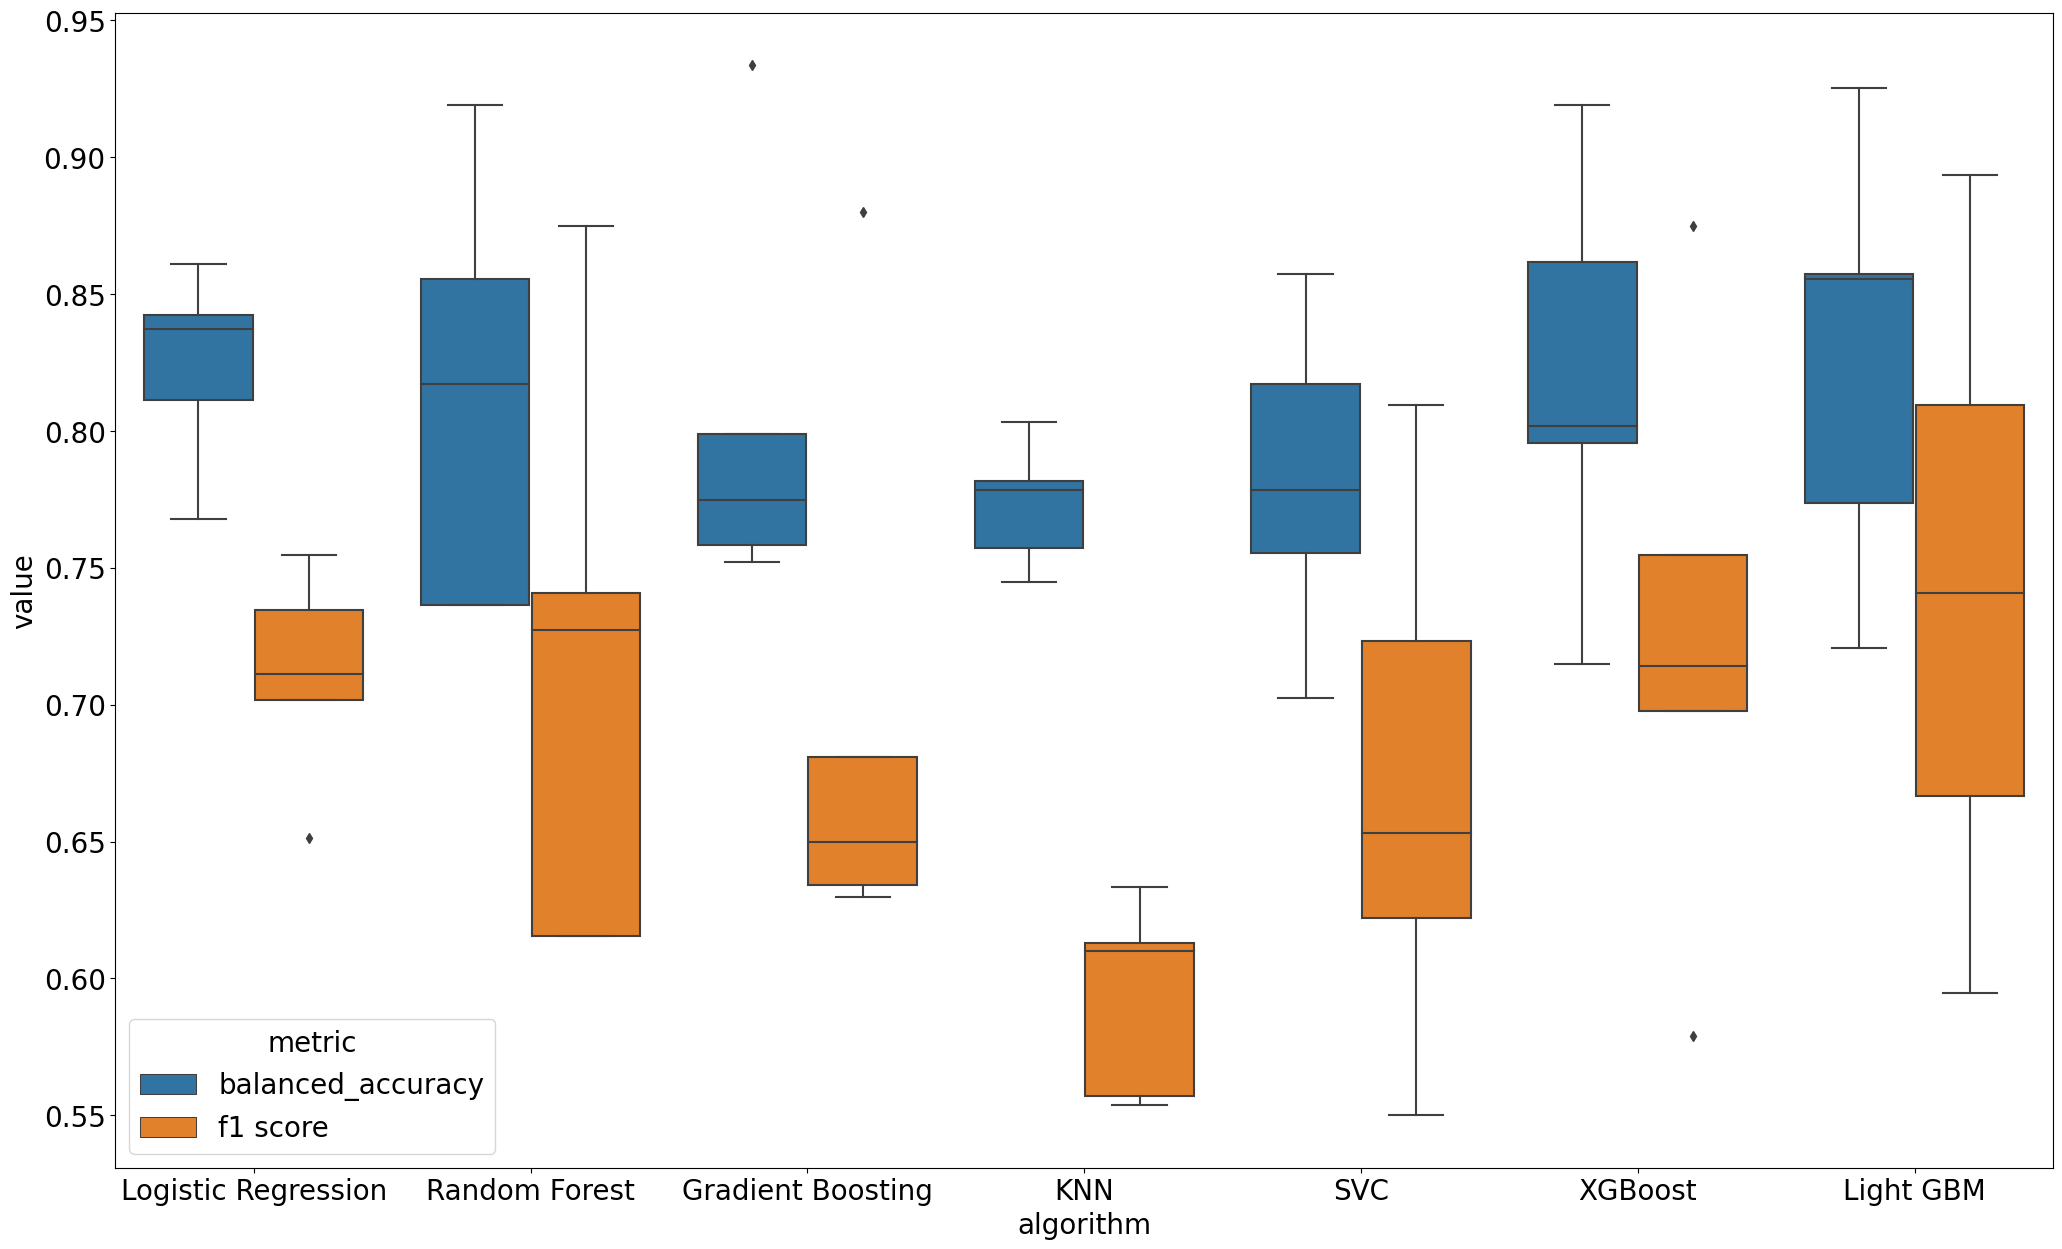

In [90]:
fig, ax = plt.subplots(figsize=(25,15))
sns.boxplot(x="algorithm", y="value", data=melted, hue="metric", ax=ax, meanline=True)

Text(0, 0.5, '')

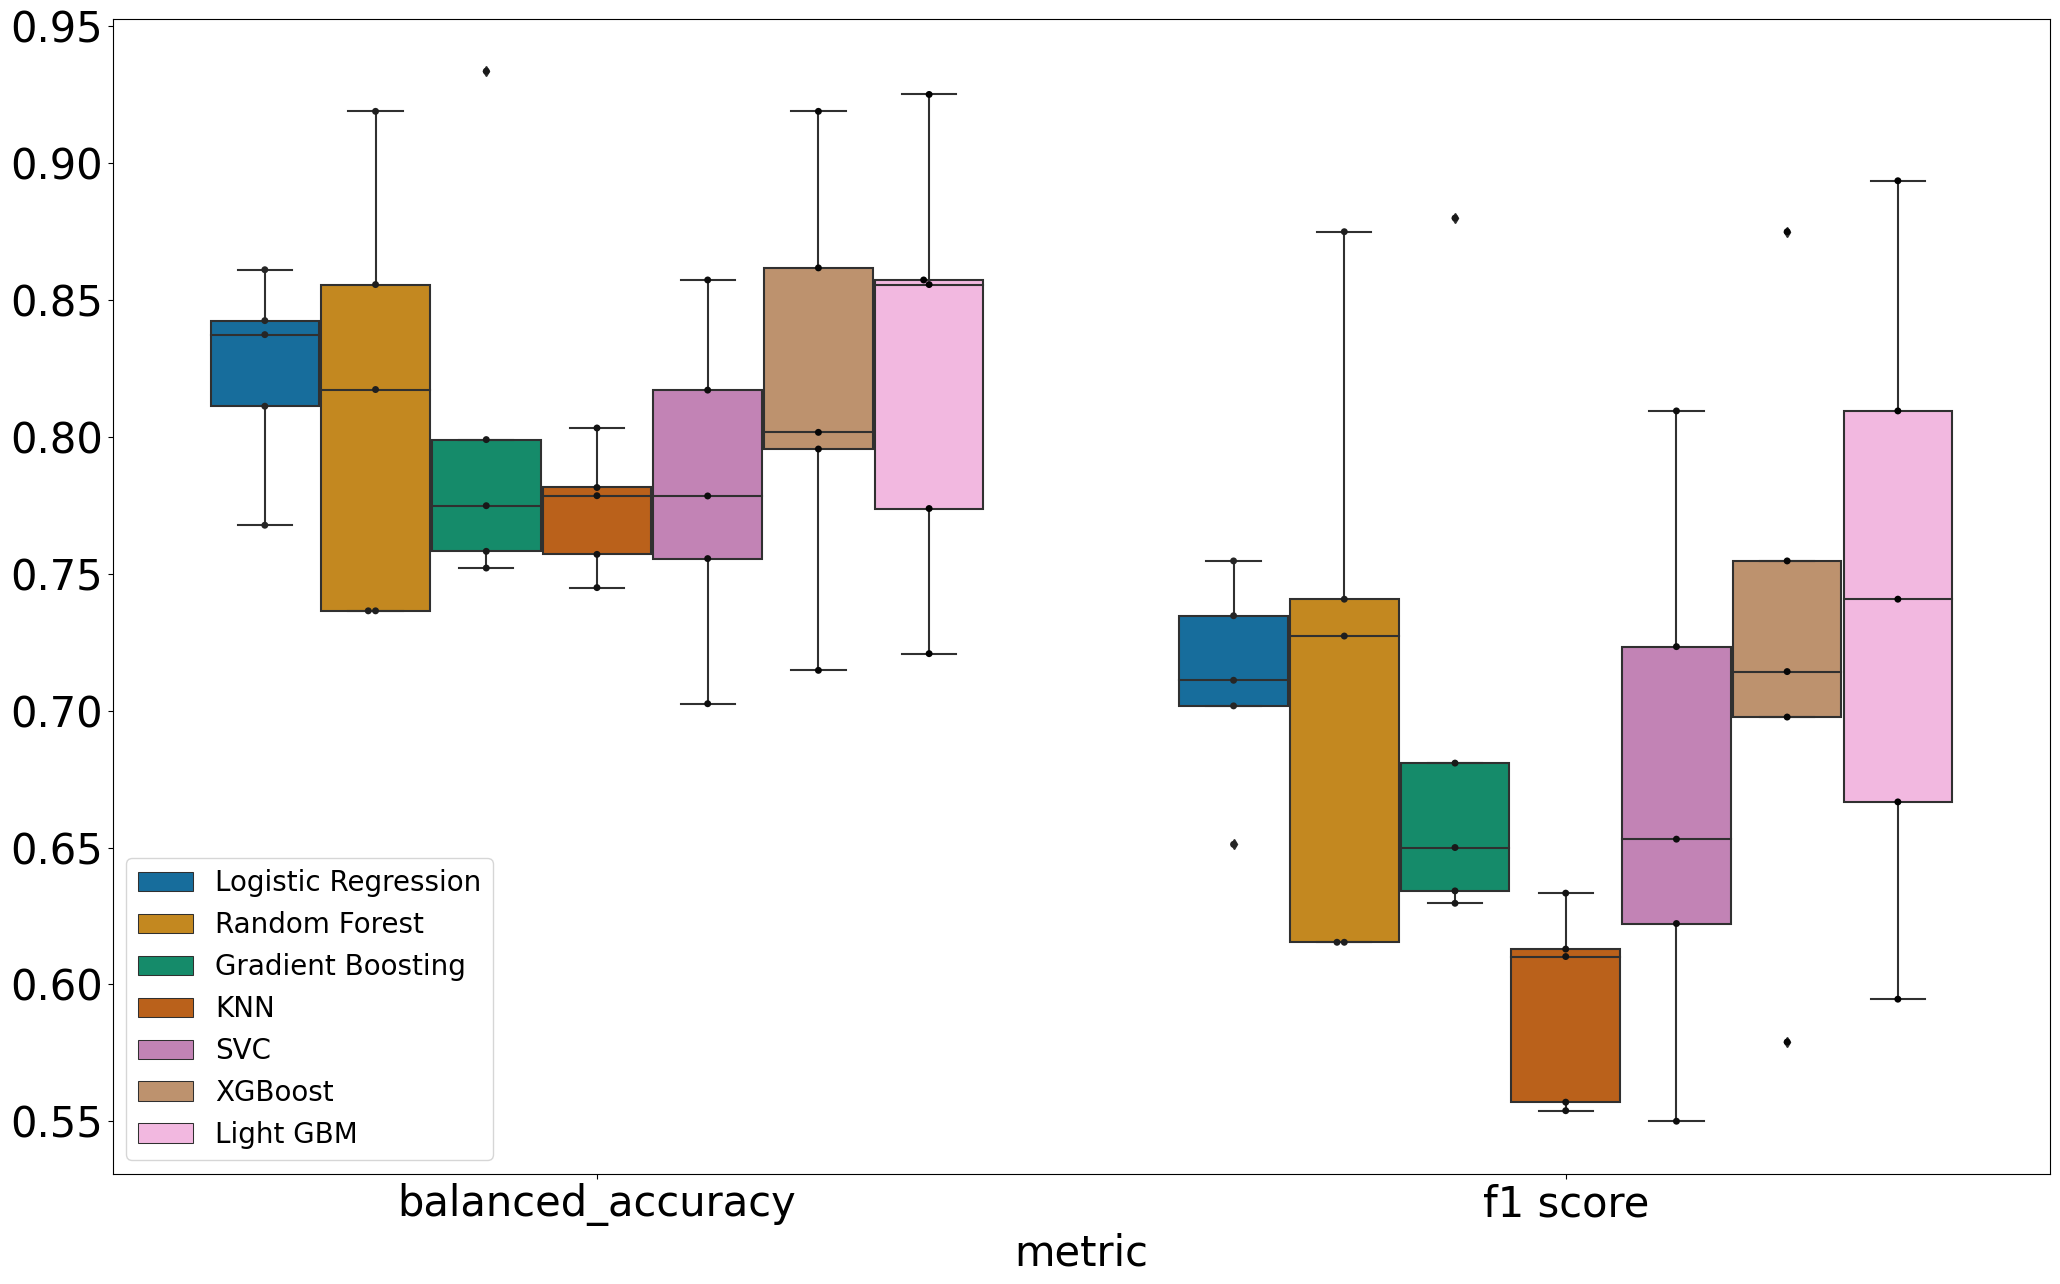

In [91]:
rcParams["font.size"] = 30
fig, ax = plt.subplots(figsize=(25,15))
sns.boxplot(x="metric", y="value", data=melted, hue="algorithm", ax=ax, palette="colorblind")
sns.swarmplot(x="metric", y="value", data=melted, hue="algorithm", ax=ax, dodge=True, color="k")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:7], labels[:7], fontsize=20)
ax.set_ylabel(None)

In [92]:
fig.savefig("cv_res_combined.pdf")